## 1T. Тема 3.2 Сверточные и полносвязные нейронные сети. Задание

## Задание

Используя набор данных MNIST, создайте свёрточную сеть классификации рукописных цифр. Сравните accuracy с полносвязной сетью из предыдущей темы. Сделайте выводы.

## Загрузка необходимых модулей

In [2]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [31]:
import numpy as np # Подключаем библиотеку numpy
import pandas as pd # Библиотека pandas
import matplotlib.pyplot as plt #Отрисовка изображений
import seaborn as sns # seaborn, надстройка визуализации над matplotlib
import pylab # Модуль для построения графиков
import tensorflow as tf

from tensorflow import keras
from keras.datasets import mnist #Библиотека с базой Mnist
from keras.models import Sequential # Подлючаем класс создания модели Sequential
from keras.layers import Dense, Flatten, MaxPooling1D # Подключаем класс Dense - полносвязный слой, и Flatten - данные выстраиваем в линию, одномерные
from keras.optimizers import Adam, RMSprop # Подключаем оптимизатор
from keras import utils #Утилиты для to_categorical
from keras.preprocessing import image #Для отрисовки изображения
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler # для нормализации данных
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasClassifier, KerasRegressor

from PIL import Image #Отрисовка изображений

%matplotlib inline

## Выборки данных, подготовка

### Загружаем данные MNIST

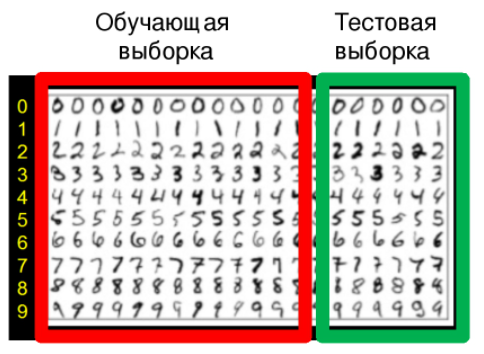

В TensorFlow, частью которого сейчас является Keras, есть тренировочные наборы данных, которые встроены в сам фреймворк. Загрузите датасет MNIST используя tensorflow\keras, либо загрузите его по ссылке : https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

In [4]:
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data() #Загрузка данных Mnist

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
print(x_train_org.shape)
print(y_train_org.shape)
print(x_test_org.shape)
print(y_test_org.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
x_train_org[0].shape

(28, 28)

### Пример - выводим на экран картинку цифры из массива

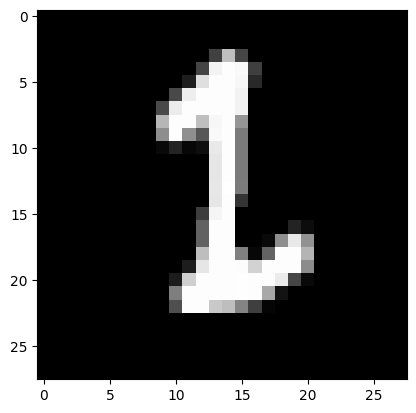

In [7]:
def show_image(n):
  plt.imshow(Image.fromarray(x_train_org[n]).convert('RGB')) #Отрисовка картинки
  plt.show() # Вывод картинки

show_image(70)

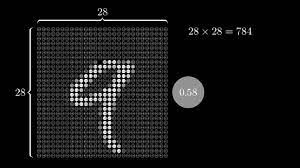

### Переводим данные в тип float
Данный тип (с плавающей точкой) необходим сетям Керас для обучения:

In [8]:
x_train_2D = x_train_org.astype('float32') # преобразовываем x_train в тип float (цифры с плавающей точкой)
x_test_2D = x_test_org.astype('float32') # преобразовываем x_test в тип float (цифры с плавающей точкой)

### Нормализуем данные
В данном случае можно использовать простой вариант. Цветов всего 255, и меняются они через равные промежутки, поэтому удобно не применять скейлер, а поделить массив на 255. Вообще, данные стараются свести все к одинаковому диапазону, обычно 0...1. Это нужно для того, чтобы все признаки одинаково оценивались нейросетью, без значительного перекоса в сторону тех, которые больше и потому сеть им уделяет больше внимания.

In [9]:
x_train_2D = x_train_2D / 255 # делим на 255, чтобы диапазон был от 0 до 1
x_test_2D = x_test_2D / 255 # делим на 255, чтобы диапазон был от 0 до 1

In [10]:
print(np.unique(x_train_2D)) # какие значения в массиве после нормализации
print(np.unique(x_test_2D))

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.3490196

### Переводим метки в формат One Hot Encoding (OHE)

При кодировании в OHE, вместо числа получаем вектор из всех нулей, кроме одной цифры - вместо нуля на той позиции (индексе), которой соответствует кодируемая цифра, стоит 1.

In [11]:
#Меняем формат входных картинок с 28х28 на 784х1
x_train = x_train_2D.reshape(60000, 784)
x_test = x_test_2D.reshape(10000, 784)
print(x_train_2D.shape)
print(x_train.shape)

(60000, 28, 28)
(60000, 784)


In [12]:
# используйте модуль utils библиотеки keras, оттуда используйте метод to_categorical как в скринкасте
# Преобразуем ответы в формат one_hot_encoding
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [13]:
y_train_org[70]

1

In [14]:
#Выводим размер y_train
#60 тысяч примеров, каждый размера 10 (так как 10 классов)
print(y_train.shape)

(60000, 10)


In [15]:
print(y_train[70]) #Выводим пример одного выходного вектора

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
print(y_train[70,1]) #Выводим пример цифры по индексу

1.0


In [17]:
print(y_train_org.shape)
print(y_train_org[70])

(60000,)
1


### Создаём модель Sequential (c помощью функции как в предыдущем задании)

**Sequential** - это последовательная модель, в которой слои нейронной сети укладываются последовательно, как слои в блинном пироге. (Можно взять архитектуру модели по аналогии со скринкастом)

In [18]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Не забудьте определить входной размер матрицы img_shape=(28,28,1), при передаче его в первый сверточный слой
# в качестве параметра input_shape
# Далее в последующих слоях можно не указывать input_shape, т.к keras сделает все преобразования за вас

In [19]:
def baseline_model():
    # create model
    img_shape=(28,28)

    model = Sequential([
        keras.layers.Dense(800, input_shape=img_shape, activation="relu"),
        keras.layers.MaxPooling1D(),
        keras.layers.Flatten(), # Вытягиваем данные в одномерный вектор только для классификационного слоя
        keras.layers.Dense(400, activation="relu"), # Добавляем полносвязный слой на 400 нейронов с relu-активацией
        keras.layers.Dense(10, activation="softmax"), # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = baseline_model()

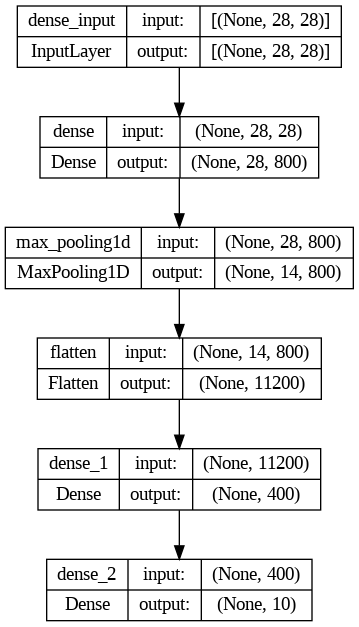

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 800)           23200     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 800)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 11200)             0         
                                                                 
 dense_1 (Dense)             (None, 400)               4480400   
                                                                 
 dense_2 (Dense)             (None, 10)                4010      
                                                                 
Total params: 4,507,610
Trainable params: 4,507,610
Non-trainable params: 0
______________________________________________

Обучаем модель

In [22]:
model_fit = model.fit(
    x_train_2D,
    y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_test_2D , y_test),
)

Epoch 1/10
469/469 [==============================] - 8s 8ms/step - loss: 0.2012 - accuracy: 0.9411 - val_loss: 0.0943 - val_accuracy: 0.9698
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0770 - accuracy: 0.9757 - val_loss: 0.0815 - val_accuracy: 0.9763
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0829 - val_accuracy: 0.9745
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0410 - accuracy: 0.9866 - val_loss: 0.0960 - val_accuracy: 0.9752
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.1120 - val_accuracy: 0.9717
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0969 - val_accuracy: 0.9770
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.1159 - val_accuracy: 0.9749
Epoch 

**По метрике accuracy мы получили достаточно высокие значения: на обучающей выборке 0.99, а на тестовой 0.98**

#### Выводим график точности на обучающей и валидационной выборке


In [23]:
print(model_fit.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


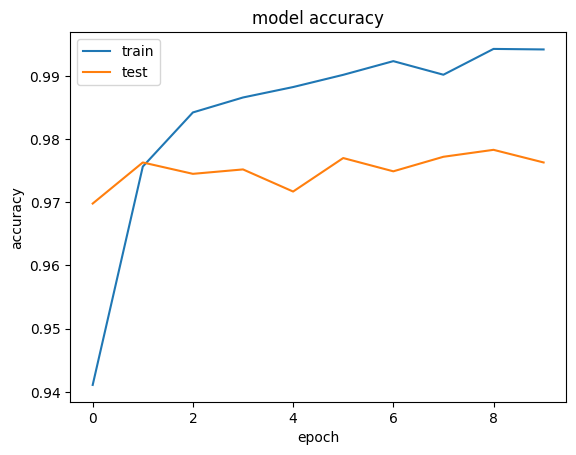

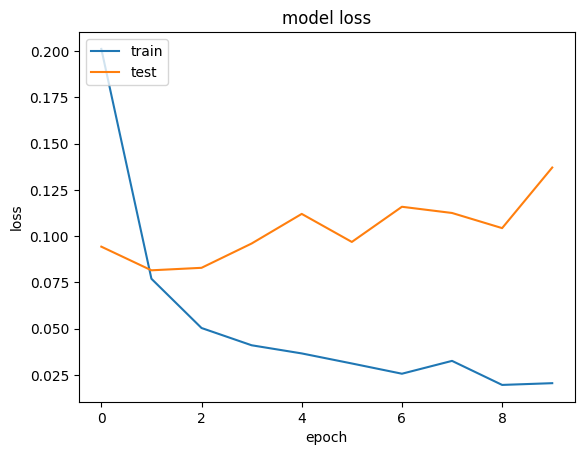

In [24]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Что мы видим на графиках:**
*   accuracy - Метрика на тренировочной выборке всегда растет, а на тестовой выборке находится примерно на одном уровне
*   loss - Ошибка на тренировочной выборке всегда уменьшается, а на тестовой выборке после 1 эпохи приростает

##### Строим матрицу ошибок

In [25]:
predictions_one_hot = model.predict(x_test_2D)
cm = confusion_matrix(y_test.argmax(axis=1), predictions_one_hot.argmax(axis=1))
print(cm)

313/313 [==============================] - 1s 2ms/step
[[ 964    0    3    0    0    1    5    1    2    4]
 [   0 1127    1    0    0    1    1    0    5    0]
 [   1    3 1009    4    0    0    0   13    1    1]
 [   0    0    8  990    0    4    0    3    2    3]
 [   0    0    3    0  949    0    6    1    2   21]
 [   2    0    0   19    1  858    4    1    2    5]
 [   3    2    4    0    1    6  938    0    4    0]
 [   0    6    4    2    0    0    0 1001    0   15]
 [   1    0    2    5    2    2    0    7  946    9]
 [   1    2    5    6    5    3    0    5    1  981]]


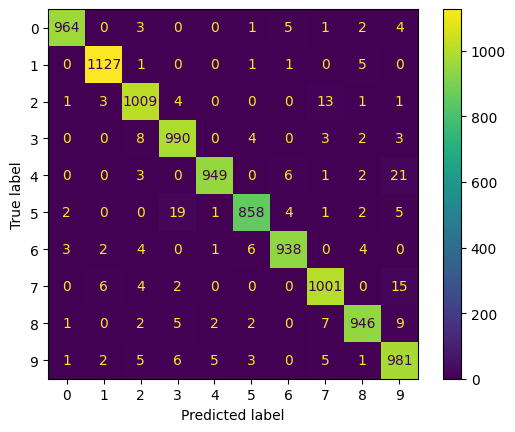

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**Что мы видим на матрице ошибок (ConfusionMatrix):**
*   В целом, модель правильно определила большинство цифр (что было понятно и из метрики accuracy)

**ПРОМЕЖУТОЧНЫЙ ВЫВОД: Мы получили высокие показатели модели (accuracy на тестовой 0.98), модель совершала небольшое количество ошибок**

### 2. Задание ПРО (Не обязательно к выполнению). Используя GridSearch, оптимизируйте свёрточную нейронную сеть для наилучшей классификации. Также, подберите для неё наилучший по параметрам регуляризатор. Сделайте выводы.

In [36]:
model_for_grid = KerasClassifier(build_fn=baseline_model)

random_search = GridSearchCV(estimator=model_for_grid,
                            param_grid={
                                'epochs':[2, 5, 10],
                                'batch_size':[1024, 2048, 4096],
                                'optimizer':['adam', 'rmsprop']},
                            scoring="accuracy")
random_search.fit(x_train_2D, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 27ms/step - loss: 0.4868 - accuracy: 0.8595
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 28ms/step - loss: 0.6386 - accuracy: 0.8381
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 26ms/step - loss: 0.4848 - accuracy: 0.8579
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 27ms/step - loss: 0.5568 - accuracy: 0.8425
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 26ms/step - loss: 0.5376 - accuracy: 0.8494
Epoch 2/2
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 28ms/step - loss: 0.5416 - accuracy: 0.8474
Epoch 2/2
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 28ms/step - loss: 0.6046 - accuracy: 0.8345
Epoch 2/2
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 27ms/step - loss: 0.5382 - accuracy: 0.8510
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 27ms/step - loss: 0.5449 - accuracy: 0.8525
Epoch 2/2
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
47/47 [==============================] - 2s 28ms/step - loss: 0.5428 - accuracy: 0.8569
Epoch 2/2
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.5124 - accuracy: 0.8545
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1064 - accuracy: 0.9669
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0680 - accuracy: 0.9786
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0450 - accuracy: 0.9856
Epoch 5/5
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 28ms/step - loss: 0.4807 - accuracy: 0.8574
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1098 - accuracy: 0.9669
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0694 - accuracy: 0.9782
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0471 - accuracy: 0.9849
Epoch 5/5
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.5592 - accuracy: 0.8512
Epoch 2/5
47/47 [==============================] - 1s 26ms/step - loss: 0.1077 - accuracy: 0.9674
Epoch 3/5
47/47 [==============================] - 1s 26ms/step - loss: 0.0686 - accuracy: 0.9787
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0477 - accuracy: 0.9851
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 29s 27ms/step - loss: 0.5258 - accuracy: 0.8597
Epoch 2/5
47/47 [==============================] - 1s 26ms/step - loss: 0.1053 - accuracy: 0.9674
Epoch 3/5
47/47 [==============================] - 1s 26ms/step - loss: 0.0663 - accuracy: 0.9796
Epoch 4/5
47/47 [==============================] - 1s 26ms/step - loss: 0.0452 - accuracy: 0.9861
Epoch 5/5
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 28ms/step - loss: 0.6143 - accuracy: 0.8367
Epoch 2/5
47/47 [==============================] - 1s 26ms/step - loss: 0.1139 - accuracy: 0.9659
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0705 - accuracy: 0.9784
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0501 - accuracy: 0.9845
Epoch 5/5
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.6264 - accuracy: 0.8393
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1148 - accuracy: 0.9652
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0729 - accuracy: 0.9769
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0481 - accuracy: 0.9850
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.6203 - accuracy: 0.8324
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1105 - accuracy: 0.9664
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0667 - accuracy: 0.9798
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0437 - accuracy: 0.9867
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.5948 - accuracy: 0.8323
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1108 - accuracy: 0.9666
Epoch 3/5
47/47 [==============================] - 1s 28ms/step - loss: 0.0683 - accuracy: 0.9789
Epoch 4/5
47/47 [==============================] - 1s 28ms/step - loss: 0.0456 - accuracy: 0.9862
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 27ms/step - loss: 0.6442 - accuracy: 0.8287
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 0.1107 - accuracy: 0.9670
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0706 - accuracy: 0.9789
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0482 - accuracy: 0.9856
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
47/47 [==============================] - 2s 29ms/step - loss: 0.5180 - accuracy: 0.8526
Epoch 2/5
47/47 [==============================] - 1s 28ms/step - loss: 0.1103 - accuracy: 0.9663
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0651 - accuracy: 0.9798
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.0438 - accuracy: 0.9861
Epoch 5/5
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 27ms/step - loss: 0.6846 - accuracy: 0.8229
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1131 - accuracy: 0.9659
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0686 - accuracy: 0.9793
Epoch 4/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0443 - accuracy: 0.9865
Epoch 5/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0288 - accuracy: 0.9910
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0182 - accuracy: 0.9947
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0129 - accuracy: 0.9963
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 9/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0069 - accuracy: 0.9980
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 27ms/step - loss: 0.5354 - accuracy: 0.8485
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1106 - accuracy: 0.9667
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0704 - accuracy: 0.9786
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0465 - accuracy: 0.9855
Epoch 5/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0323 - accuracy: 0.9904
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0226 - accuracy: 0.9928
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0127 - accuracy: 0.9965
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0073 - accuracy: 0.9982
Epoch 9/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0046 - accuracy: 0.9991
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 27ms/step - loss: 0.5713 - accuracy: 0.8434
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1068 - accuracy: 0.9679
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0668 - accuracy: 0.9787
Epoch 4/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0440 - accuracy: 0.9861
Epoch 5/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0297 - accuracy: 0.9909
Epoch 6/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0198 - accuracy: 0.9942
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0150 - accuracy: 0.9955
Epoch 8/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0104 - accuracy: 0.9973
Epoch 9/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0088 - accuracy: 0.9976
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 28ms/step - loss: 0.5032 - accuracy: 0.8500
Epoch 2/10
47/47 [==============================] - 1s 28ms/step - loss: 0.1106 - accuracy: 0.9668
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0683 - accuracy: 0.9790
Epoch 4/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0442 - accuracy: 0.9869
Epoch 5/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0275 - accuracy: 0.9918
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0170 - accuracy: 0.9952
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0105 - accuracy: 0.9971
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0086 - accuracy: 0.9976
Epoch 9/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0070 - accuracy: 0.9980
Epoch 10/10
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 28ms/step - loss: 0.5764 - accuracy: 0.8375
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1113 - accuracy: 0.9660
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0700 - accuracy: 0.9781
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0459 - accuracy: 0.9856
Epoch 5/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0304 - accuracy: 0.9904
Epoch 6/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0212 - accuracy: 0.9933
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0166 - accuracy: 0.9944
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0098 - accuracy: 0.9972
Epoch 9/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0054 - accuracy: 0.9987
Epoch 10/10
12/12 [==============================] - 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 28ms/step - loss: 0.5191 - accuracy: 0.8522
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1086 - accuracy: 0.9670
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0681 - accuracy: 0.9787
Epoch 4/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0466 - accuracy: 0.9851
Epoch 5/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0292 - accuracy: 0.9907
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0175 - accuracy: 0.9949
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0134 - accuracy: 0.9959
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 9/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0070 - accuracy: 0.9982
Epoch 10/10
12/12 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 29ms/step - loss: 0.5091 - accuracy: 0.8520
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1073 - accuracy: 0.9683
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0674 - accuracy: 0.9792
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0446 - accuracy: 0.9861
Epoch 5/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0325 - accuracy: 0.9895
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0198 - accuracy: 0.9940
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0128 - accuracy: 0.9961
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0070 - accuracy: 0.9984
Epoch 9/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0055 - accuracy: 0.9986
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 27ms/step - loss: 0.5276 - accuracy: 0.8511
Epoch 2/10
47/47 [==============================] - 1s 26ms/step - loss: 0.1070 - accuracy: 0.9677
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0647 - accuracy: 0.9805
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0437 - accuracy: 0.9864
Epoch 5/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0315 - accuracy: 0.9904
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0179 - accuracy: 0.9948
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0124 - accuracy: 0.9966
Epoch 8/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0099 - accuracy: 0.9972
Epoch 9/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0086 - accuracy: 0.9977
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 27ms/step - loss: 0.5259 - accuracy: 0.8528
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1101 - accuracy: 0.9668
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0661 - accuracy: 0.9799
Epoch 4/10
47/47 [==============================] - 1s 28ms/step - loss: 0.0445 - accuracy: 0.9864
Epoch 5/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0327 - accuracy: 0.9894
Epoch 6/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0203 - accuracy: 0.9938
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0140 - accuracy: 0.9958
Epoch 8/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0084 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0062 - accuracy: 0.9984
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
47/47 [==============================] - 2s 26ms/step - loss: 0.6237 - accuracy: 0.8339
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1107 - accuracy: 0.9661
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0710 - accuracy: 0.9776
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0467 - accuracy: 0.9855
Epoch 5/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0346 - accuracy: 0.9892
Epoch 6/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0233 - accuracy: 0.9926
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0137 - accuracy: 0.9962
Epoch 8/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0083 - accuracy: 0.9979
Epoch 9/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0056 - accuracy: 0.9986
Epoch 10/10
12/12 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 51ms/step - loss: 0.9153 - accuracy: 0.7538
Epoch 2/2
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 49ms/step - loss: 0.9000 - accuracy: 0.7586
Epoch 2/2
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 51ms/step - loss: 0.8326 - accuracy: 0.7655
Epoch 2/2
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 51ms/step - loss: 0.8888 - accuracy: 0.7513
Epoch 2/2
6/6 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 49ms/step - loss: 0.8591 - accuracy: 0.7634
Epoch 2/2
6/6 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 49ms/step - loss: 0.9335 - accuracy: 0.7581
Epoch 2/2
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 50ms/step - loss: 0.9307 - accuracy: 0.7481
Epoch 2/2
6/6 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 50ms/step - loss: 0.7687 - accuracy: 0.7690
Epoch 2/2
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 50ms/step - loss: 0.8246 - accuracy: 0.7719
Epoch 2/2
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
24/24 [==============================] - 2s 49ms/step - loss: 0.9888 - accuracy: 0.7400
Epoch 2/2
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 53ms/step - loss: 0.9494 - accuracy: 0.7539
Epoch 2/5
24/24 [==============================] - 1s 51ms/step - loss: 0.1762 - accuracy: 0.9469
Epoch 3/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1033 - accuracy: 0.9695
Epoch 4/5
24/24 [==============================] - 1s 50ms/step - loss: 0.0720 - accuracy: 0.9777
Epoch 5/5
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 50ms/step - loss: 0.9126 - accuracy: 0.7633
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1744 - accuracy: 0.9485
Epoch 3/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1037 - accuracy: 0.9687
Epoch 4/5
24/24 [==============================] - 1s 51ms/step - loss: 0.0735 - accuracy: 0.9778
Epoch 5/5
6/6 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 53ms/step - loss: 0.9150 - accuracy: 0.7625
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1765 - accuracy: 0.9481
Epoch 3/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1047 - accuracy: 0.9683
Epoch 4/5
24/24 [==============================] - 1s 50ms/step - loss: 0.0723 - accuracy: 0.9773
Epoch 5/5
6/6 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 50ms/step - loss: 0.9778 - accuracy: 0.7412
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1770 - accuracy: 0.9470
Epoch 3/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1052 - accuracy: 0.9688
Epoch 4/5
24/24 [==============================] - 1s 50ms/step - loss: 0.0712 - accuracy: 0.9786
Epoch 5/5
6/6 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 51ms/step - loss: 0.9912 - accuracy: 0.7373
Epoch 2/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1797 - accuracy: 0.9456
Epoch 3/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1067 - accuracy: 0.9681
Epoch 4/5
24/24 [==============================] - 1s 49ms/step - loss: 0.0738 - accuracy: 0.9783
Epoch 5/5
6/6 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 51ms/step - loss: 0.9670 - accuracy: 0.7452
Epoch 2/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1750 - accuracy: 0.9466
Epoch 3/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1076 - accuracy: 0.9673
Epoch 4/5
24/24 [==============================] - 1s 49ms/step - loss: 0.0776 - accuracy: 0.9765
Epoch 5/5
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 50ms/step - loss: 0.7794 - accuracy: 0.7854
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1671 - accuracy: 0.9506
Epoch 3/5
24/24 [==============================] - 1s 51ms/step - loss: 0.1012 - accuracy: 0.9692
Epoch 4/5
24/24 [==============================] - 1s 53ms/step - loss: 0.0721 - accuracy: 0.9778
Epoch 5/5
6/6 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 52ms/step - loss: 0.8597 - accuracy: 0.7563
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1750 - accuracy: 0.9462
Epoch 3/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1054 - accuracy: 0.9674
Epoch 4/5
24/24 [==============================] - 1s 52ms/step - loss: 0.0736 - accuracy: 0.9773
Epoch 5/5
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 50ms/step - loss: 0.8525 - accuracy: 0.7701
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1614 - accuracy: 0.9522
Epoch 3/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1015 - accuracy: 0.9698
Epoch 4/5
24/24 [==============================] - 1s 50ms/step - loss: 0.0729 - accuracy: 0.9784
Epoch 5/5
6/6 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
24/24 [==============================] - 2s 52ms/step - loss: 0.8299 - accuracy: 0.7546
Epoch 2/5
24/24 [==============================] - 1s 50ms/step - loss: 0.1758 - accuracy: 0.9470
Epoch 3/5
24/24 [==============================] - 1s 49ms/step - loss: 0.1066 - accuracy: 0.9672
Epoch 4/5
24/24 [==============================] - 1s 50ms/step - loss: 0.0766 - accuracy: 0.9768
Epoch 5/5
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 50ms/step - loss: 0.8956 - accuracy: 0.7603
Epoch 2/10
24/24 [==============================] - 1s 51ms/step - loss: 0.1684 - accuracy: 0.9490
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1017 - accuracy: 0.9694
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0722 - accuracy: 0.9780
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0527 - accuracy: 0.9836
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0395 - accuracy: 0.9886
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0292 - accuracy: 0.9915
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0197 - accuracy: 0.9948
Epoch 9/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0134 - accuracy: 0.9969
Epoch 10/10
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 51ms/step - loss: 0.9291 - accuracy: 0.7516
Epoch 2/10
24/24 [==============================] - 1s 53ms/step - loss: 0.1780 - accuracy: 0.9471
Epoch 3/10
24/24 [==============================] - 1s 51ms/step - loss: 0.1107 - accuracy: 0.9668
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0782 - accuracy: 0.9765
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0562 - accuracy: 0.9831
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0402 - accuracy: 0.9883
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0284 - accuracy: 0.9924
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0201 - accuracy: 0.9950
Epoch 9/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0159 - accuracy: 0.9957
Epoch 10/10
6/6 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 50ms/step - loss: 0.9545 - accuracy: 0.7503
Epoch 2/10
24/24 [==============================] - 1s 49ms/step - loss: 0.1746 - accuracy: 0.9471
Epoch 3/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1065 - accuracy: 0.9678
Epoch 4/10
24/24 [==============================] - 1s 53ms/step - loss: 0.0756 - accuracy: 0.9766
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0552 - accuracy: 0.9831
Epoch 6/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0381 - accuracy: 0.9884
Epoch 7/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0296 - accuracy: 0.9914
Epoch 8/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0217 - accuracy: 0.9935
Epoch 9/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0152 - accuracy: 0.9963
Epoch 10/10
6/6 [==============================] - 1s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 51ms/step - loss: 0.8861 - accuracy: 0.7410
Epoch 2/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1722 - accuracy: 0.9485
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1054 - accuracy: 0.9682
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0733 - accuracy: 0.9777
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0546 - accuracy: 0.9837
Epoch 6/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0409 - accuracy: 0.9880
Epoch 7/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0306 - accuracy: 0.9909
Epoch 8/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0225 - accuracy: 0.9942
Epoch 9/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0156 - accuracy: 0.9959
Epoch 10/10
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 53ms/step - loss: 0.9302 - accuracy: 0.7415
Epoch 2/10
24/24 [==============================] - 1s 53ms/step - loss: 0.1801 - accuracy: 0.9457
Epoch 3/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1053 - accuracy: 0.9685
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0726 - accuracy: 0.9786
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0524 - accuracy: 0.9847
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0388 - accuracy: 0.9886
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0312 - accuracy: 0.9907
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0213 - accuracy: 0.9941
Epoch 9/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0145 - accuracy: 0.9963
Epoch 10/10
6/6 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 52ms/step - loss: 0.8843 - accuracy: 0.7587
Epoch 2/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1751 - accuracy: 0.9470
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1052 - accuracy: 0.9685
Epoch 4/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0753 - accuracy: 0.9775
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0555 - accuracy: 0.9828
Epoch 6/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0415 - accuracy: 0.9871
Epoch 7/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0286 - accuracy: 0.9917
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0204 - accuracy: 0.9945
Epoch 9/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0151 - accuracy: 0.9963
Epoch 10/10
6/6 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 50ms/step - loss: 0.9943 - accuracy: 0.7454
Epoch 2/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1785 - accuracy: 0.9466
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1123 - accuracy: 0.9661
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0821 - accuracy: 0.9750
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0587 - accuracy: 0.9822
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0442 - accuracy: 0.9867
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0332 - accuracy: 0.9905
Epoch 8/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0235 - accuracy: 0.9938
Epoch 9/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0164 - accuracy: 0.9958
Epoch 10/10
6/6 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 53ms/step - loss: 1.0157 - accuracy: 0.7251
Epoch 2/10
24/24 [==============================] - 1s 53ms/step - loss: 0.1813 - accuracy: 0.9454
Epoch 3/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1092 - accuracy: 0.9667
Epoch 4/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0778 - accuracy: 0.9766
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0581 - accuracy: 0.9820
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0423 - accuracy: 0.9872
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0314 - accuracy: 0.9906
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0217 - accuracy: 0.9944
Epoch 9/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 10/10
6/6 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 54ms/step - loss: 0.8959 - accuracy: 0.7598
Epoch 2/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1726 - accuracy: 0.9485
Epoch 3/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1043 - accuracy: 0.9690
Epoch 4/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0754 - accuracy: 0.9772
Epoch 5/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0550 - accuracy: 0.9836
Epoch 6/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0395 - accuracy: 0.9885
Epoch 7/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0289 - accuracy: 0.9916
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0212 - accuracy: 0.9944
Epoch 9/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0152 - accuracy: 0.9960
Epoch 10/10
6/6 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
24/24 [==============================] - 2s 50ms/step - loss: 0.9426 - accuracy: 0.7358
Epoch 2/10
24/24 [==============================] - 1s 50ms/step - loss: 0.1905 - accuracy: 0.9441
Epoch 3/10
24/24 [==============================] - 1s 52ms/step - loss: 0.1127 - accuracy: 0.9661
Epoch 4/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0788 - accuracy: 0.9763
Epoch 5/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0580 - accuracy: 0.9827
Epoch 6/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0428 - accuracy: 0.9872
Epoch 7/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0310 - accuracy: 0.9913
Epoch 8/10
24/24 [==============================] - 1s 50ms/step - loss: 0.0206 - accuracy: 0.9947
Epoch 9/10
24/24 [==============================] - 1s 49ms/step - loss: 0.0143 - accuracy: 0.9964
Epoch 10/10
6/6 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 99ms/step - loss: 1.7305 - accuracy: 0.5497
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 101ms/step - loss: 1.3298 - accuracy: 0.6332
Epoch 2/2
3/3 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 101ms/step - loss: 1.6451 - accuracy: 0.6230
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 102ms/step - loss: 1.4918 - accuracy: 0.6351
Epoch 2/2
3/3 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 101ms/step - loss: 1.5515 - accuracy: 0.5953
Epoch 2/2
3/3 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 102ms/step - loss: 1.5017 - accuracy: 0.5935
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 102ms/step - loss: 1.2348 - accuracy: 0.6523
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 102ms/step - loss: 1.4166 - accuracy: 0.6565
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 106ms/step - loss: 1.4638 - accuracy: 0.6340
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/2
12/12 [==============================] - 2s 102ms/step - loss: 1.4627 - accuracy: 0.5947
Epoch 2/2
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 102ms/step - loss: 1.3816 - accuracy: 0.6289
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.3117 - accuracy: 0.9047
Epoch 3/5
12/12 [==============================] - 1s 100ms/step - loss: 0.1814 - accuracy: 0.9457
Epoch 4/5
12/12 [==============================] - 1s 101ms/step - loss: 0.1290 - accuracy: 0.9613
Epoch 5/5
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 100ms/step - loss: 1.4205 - accuracy: 0.6140
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.3435 - accuracy: 0.8963
Epoch 3/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1956 - accuracy: 0.9415
Epoch 4/5
12/12 [==============================] - 1s 100ms/step - loss: 0.1353 - accuracy: 0.9598
Epoch 5/5
3/3 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 100ms/step - loss: 1.4933 - accuracy: 0.6227
Epoch 2/5
12/12 [==============================] - 1s 98ms/step - loss: 0.3356 - accuracy: 0.9009
Epoch 3/5
12/12 [==============================] - 1s 98ms/step - loss: 0.1929 - accuracy: 0.9438
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1318 - accuracy: 0.9615
Epoch 5/5
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 99ms/step - loss: 1.3008 - accuracy: 0.6423
Epoch 2/5
12/12 [==============================] - 1s 103ms/step - loss: 0.3249 - accuracy: 0.9020
Epoch 3/5
12/12 [==============================] - 1s 104ms/step - loss: 0.1887 - accuracy: 0.9435
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1310 - accuracy: 0.9613
Epoch 5/5
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 100ms/step - loss: 1.4744 - accuracy: 0.6109
Epoch 2/5
12/12 [==============================] - 1s 99ms/step - loss: 0.3274 - accuracy: 0.9011
Epoch 3/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1974 - accuracy: 0.9413
Epoch 4/5
12/12 [==============================] - 1s 98ms/step - loss: 0.1385 - accuracy: 0.9583
Epoch 5/5
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 103ms/step - loss: 1.3774 - accuracy: 0.6307
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.3237 - accuracy: 0.9017
Epoch 3/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1907 - accuracy: 0.9428
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1339 - accuracy: 0.9602
Epoch 5/5
3/3 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 101ms/step - loss: 1.2638 - accuracy: 0.6740
Epoch 2/5
12/12 [==============================] - 1s 104ms/step - loss: 0.2952 - accuracy: 0.9108
Epoch 3/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1766 - accuracy: 0.9475
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1267 - accuracy: 0.9615
Epoch 5/5
3/3 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 103ms/step - loss: 1.1365 - accuracy: 0.6691
Epoch 2/5
12/12 [==============================] - 1s 103ms/step - loss: 0.2792 - accuracy: 0.9160
Epoch 3/5
12/12 [==============================] - 1s 101ms/step - loss: 0.1700 - accuracy: 0.9487
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1226 - accuracy: 0.9631
Epoch 5/5
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 100ms/step - loss: 1.5313 - accuracy: 0.6065
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.3477 - accuracy: 0.8995
Epoch 3/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1817 - accuracy: 0.9464
Epoch 4/5
12/12 [==============================] - 1s 99ms/step - loss: 0.1250 - accuracy: 0.9626
Epoch 5/5
3/3 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
12/12 [==============================] - 2s 104ms/step - loss: 1.5455 - accuracy: 0.6049
Epoch 2/5
12/12 [==============================] - 1s 100ms/step - loss: 0.3497 - accuracy: 0.8941
Epoch 3/5
12/12 [==============================] - 1s 100ms/step - loss: 0.1954 - accuracy: 0.9408
Epoch 4/5
12/12 [==============================] - 1s 100ms/step - loss: 0.1346 - accuracy: 0.9604
Epoch 5/5
3/3 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 102ms/step - loss: 1.4580 - accuracy: 0.6050
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3365 - accuracy: 0.8983
Epoch 3/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1885 - accuracy: 0.9423
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1312 - accuracy: 0.9608
Epoch 5/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1012 - accuracy: 0.9691
Epoch 6/10
12/12 [==============================] - 1s 104ms/step - loss: 0.0814 - accuracy: 0.9752
Epoch 7/10
12/12 [==============================] - 1s 103ms/step - loss: 0.0642 - accuracy: 0.9807
Epoch 8/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0509 - accuracy: 0.9852
Epoch 9/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0397 - accuracy: 0.9887
Epoch 10/10
3/3 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 101ms/step - loss: 1.4537 - accuracy: 0.6097
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3361 - accuracy: 0.9002
Epoch 3/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1928 - accuracy: 0.9416
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1364 - accuracy: 0.9590
Epoch 5/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1057 - accuracy: 0.9678
Epoch 6/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0854 - accuracy: 0.9744
Epoch 7/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0678 - accuracy: 0.9796
Epoch 8/10
12/12 [==============================] - 1s 104ms/step - loss: 0.0562 - accuracy: 0.9830
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0445 - accuracy: 0.9871
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 100ms/step - loss: 1.6541 - accuracy: 0.6150
Epoch 2/10
12/12 [==============================] - 1s 100ms/step - loss: 0.3788 - accuracy: 0.8901
Epoch 3/10
12/12 [==============================] - 1s 100ms/step - loss: 0.2037 - accuracy: 0.9404
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1379 - accuracy: 0.9595
Epoch 5/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1048 - accuracy: 0.9689
Epoch 6/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0840 - accuracy: 0.9751
Epoch 7/10
12/12 [==============================] - 1s 105ms/step - loss: 0.0683 - accuracy: 0.9798
Epoch 8/10
12/12 [==============================] - 1s 103ms/step - loss: 0.0548 - accuracy: 0.9836
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0451 - accuracy: 0.9870
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 101ms/step - loss: 1.3081 - accuracy: 0.6442
Epoch 2/10
12/12 [==============================] - 1s 101ms/step - loss: 0.3120 - accuracy: 0.9062
Epoch 3/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1838 - accuracy: 0.9456
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1330 - accuracy: 0.9610
Epoch 5/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1032 - accuracy: 0.9692
Epoch 6/10
12/12 [==============================] - 1s 103ms/step - loss: 0.0825 - accuracy: 0.9751
Epoch 7/10
12/12 [==============================] - 1s 105ms/step - loss: 0.0676 - accuracy: 0.9800
Epoch 8/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0535 - accuracy: 0.9849
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0442 - accuracy: 0.9878
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 101ms/step - loss: 1.4832 - accuracy: 0.6268
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3548 - accuracy: 0.8935
Epoch 3/10
12/12 [==============================] - 1s 100ms/step - loss: 0.2009 - accuracy: 0.9410
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1378 - accuracy: 0.9597
Epoch 5/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1053 - accuracy: 0.9685
Epoch 6/10
12/12 [==============================] - 1s 104ms/step - loss: 0.0833 - accuracy: 0.9752
Epoch 7/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0674 - accuracy: 0.9800
Epoch 8/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0546 - accuracy: 0.9841
Epoch 9/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0440 - accuracy: 0.9875
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 99ms/step - loss: 1.3222 - accuracy: 0.6485
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3118 - accuracy: 0.9081
Epoch 3/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1794 - accuracy: 0.9456
Epoch 4/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1266 - accuracy: 0.9619
Epoch 5/10
12/12 [==============================] - 1s 105ms/step - loss: 0.0984 - accuracy: 0.9706
Epoch 6/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0790 - accuracy: 0.9760
Epoch 7/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0625 - accuracy: 0.9815
Epoch 8/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0496 - accuracy: 0.9852
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0403 - accuracy: 0.9884
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 99ms/step - loss: 1.4689 - accuracy: 0.5952
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3382 - accuracy: 0.8973
Epoch 3/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1941 - accuracy: 0.9418
Epoch 4/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1373 - accuracy: 0.9589
Epoch 5/10
12/12 [==============================] - 1s 102ms/step - loss: 0.1059 - accuracy: 0.9687
Epoch 6/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0851 - accuracy: 0.9743
Epoch 7/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0677 - accuracy: 0.9796
Epoch 8/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0541 - accuracy: 0.9839
Epoch 9/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0435 - accuracy: 0.9876
Epoch 10/10
3/3 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 99ms/step - loss: 1.5751 - accuracy: 0.6207
Epoch 2/10
12/12 [==============================] - 1s 99ms/step - loss: 0.3485 - accuracy: 0.8970
Epoch 3/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1964 - accuracy: 0.9425
Epoch 4/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1356 - accuracy: 0.9603
Epoch 5/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1041 - accuracy: 0.9690
Epoch 6/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0830 - accuracy: 0.9755
Epoch 7/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0667 - accuracy: 0.9804
Epoch 8/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0543 - accuracy: 0.9841
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0432 - accuracy: 0.9876
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 104ms/step - loss: 1.4442 - accuracy: 0.6349
Epoch 2/10
12/12 [==============================] - 1s 104ms/step - loss: 0.3270 - accuracy: 0.9022
Epoch 3/10
12/12 [==============================] - 1s 104ms/step - loss: 0.1943 - accuracy: 0.9422
Epoch 4/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1358 - accuracy: 0.9596
Epoch 5/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1040 - accuracy: 0.9694
Epoch 6/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0834 - accuracy: 0.9753
Epoch 7/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0685 - accuracy: 0.9795
Epoch 8/10
12/12 [==============================] - 1s 99ms/step - loss: 0.0559 - accuracy: 0.9838
Epoch 9/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0449 - accuracy: 0.9870
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
12/12 [==============================] - 2s 100ms/step - loss: 1.4224 - accuracy: 0.6006
Epoch 2/10
12/12 [==============================] - 1s 103ms/step - loss: 0.3578 - accuracy: 0.8904
Epoch 3/10
12/12 [==============================] - 1s 103ms/step - loss: 0.1988 - accuracy: 0.9400
Epoch 4/10
12/12 [==============================] - 1s 99ms/step - loss: 0.1348 - accuracy: 0.9601
Epoch 5/10
12/12 [==============================] - 1s 100ms/step - loss: 0.1025 - accuracy: 0.9696
Epoch 6/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0801 - accuracy: 0.9765
Epoch 7/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0643 - accuracy: 0.9812
Epoch 8/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0513 - accuracy: 0.9849
Epoch 9/10
12/12 [==============================] - 1s 100ms/step - loss: 0.0391 - accuracy: 0.9892
Epoch 10/10
3/3 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
59/59 [==============================] - 2s 28ms/step - loss: 0.4759 - accuracy: 0.8641
Epoch 2/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0938 - accuracy: 0.9710
Epoch 3/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0601 - accuracy: 0.9813
Epoch 4/10
59/59 [==============================] - 2s 26ms/step - loss: 0.0387 - accuracy: 0.9881
Epoch 5/10
59/59 [==============================] - 2s 26ms/step - loss: 0.0278 - accuracy: 0.9910
Epoch 6/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0209 - accuracy: 0.9933
Epoch 7/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0125 - accuracy: 0.9960
Epoch 8/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0068 - accuracy: 0.9982
Epoch 9/10
59/59 [==============================] - 2s 28ms/step - loss: 0.0046 - accuracy: 0.9989
Epoch 10/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0075 - accuracy: 0.9977


GridSearchCV(estimator=KerasClassifier(build_fn=<function baseline_model at 0x7e9c92906c20>),
             param_grid={'batch_size': [1024, 2048, 4096], 'epochs': [2, 5, 10],
                         'optimizer': ['adam', 'rmsprop']},
             scoring='accuracy')

In [37]:
random_search.best_params_

{'batch_size': 1024, 'epochs': 10, 'optimizer': 'adam'}

Мы нашли наилучшие параметры, обучим модель

In [38]:
model_gs = baseline_model()

model_fit_gs = model_gs.fit(
    x_train_2D,
    y_train,
    batch_size=1024,
    epochs=10,
    verbose=1,
    validation_data=(x_test_2D , y_test),
)

Epoch 1/10
59/59 [==============================] - 2s 32ms/step - loss: 0.5122 - accuracy: 0.8563 - val_loss: 0.1267 - val_accuracy: 0.9615
Epoch 2/10
59/59 [==============================] - 2s 28ms/step - loss: 0.0950 - accuracy: 0.9708 - val_loss: 0.0850 - val_accuracy: 0.9719
Epoch 3/10
59/59 [==============================] - 2s 28ms/step - loss: 0.0585 - accuracy: 0.9820 - val_loss: 0.0706 - val_accuracy: 0.9770
Epoch 4/10
59/59 [==============================] - 2s 32ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0728 - val_accuracy: 0.9756
Epoch 5/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.0663 - val_accuracy: 0.9799
Epoch 6/10
59/59 [==============================] - 2s 31ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.0665 - val_accuracy: 0.9800
Epoch 7/10
59/59 [==============================] - 2s 31ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.0723 - val_accuracy: 0.9784
Epoch 8/10
59

# ОБЩИЙ ВЫВОД
У первой модели мы получили val_accuracy: 0.9763, а после GridSearchCV val_accuracy: 0.9832, т.е. у нас получилось повысить качество модели.

## Литература


1. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

2. https://creativecommons.org/licenses/by/4.0/

3. https://cs.stanford.edu/~acoates/stl10/

4. https://www.tensorflow.org/datasets/catalog/overview

5. https://keras.io/api/datasets/

6. https://en.wikipedia.org/wiki/Sensitivity_and_specificity

7. https://en.m.wikipedia.org/wiki/Batch_normalization#:~:text=Batch%20normalization%20(also%20known%20as,and%20Christian%20Szegedy%20in%202015.)

8. https://jmlr.org/papers/v15/srivastava14a.html

9. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

10. https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/

11. https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

12. Автор: Max La - собственная работа, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=33394271

13. Y. LeCun, B. Boser, J. S. Denker, D. Henderson, R. E. Howard, W. Hubbard and L. D. Jackel: Backpropagation Applied to Handwritten Zip Code Recognition, Neural Computation, 1(4):541-551, Winter 1989.

14. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/






